# Глубокое обучение


## Тема 2. Вариационные автокодировщики (продолжение)👖
 

Импортируем нужные библиотеки:

In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"            # "jax" "tensorflow" "torch"
#os.environ["ENABLE_PJRT_COMPATIBILITY"] = "1"   # added for jax
#os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1" # added for torch

In [2]:
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

In [3]:
#%load_ext autoreload
#%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import keras
keras.__version__, keras.backend.backend()

('3.9.2', 'tensorflow')

In [4]:
from keras import (
    layers,
    models,
    datasets,
    callbacks,
    losses,
    optimizers,
    metrics,
    utils,
)

### Создание новых слоев и моделей как производных от базовых классов

#### Создание новых слоев

Одним из центральных классов Keras является класс `Layer` (слой). Класс `Layer` инкапсулирует как состояние («веса») слоя, так и преобразование из входов в выходы (метод `call()`, прямой проход слоя).

Рассмотрим следующий полносвязанный слой `Linear`, у которого есть две переменные состояния – переменные `w` и `b`:

In [5]:
from keras import ops

class Linear(keras.layers.Layer):
    def __init__(self, units=32, input_dim=32):
        super().__init__()
        self.w = self.add_weight(
            shape=(input_dim, units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(shape=(units,), initializer="zeros", trainable=True)

    def call(self, inputs):
        return ops.matmul(inputs, self.w) + self.b

Можно использовать слой `Linear`, вызывая его для каких-нибудь входных данных в виде тензора (подобно функции Python):

In [6]:
x = ops.ones((3, 3))      # единичная матрица 3 на 3
lin_layer = Linear(4, 3)  # 4 нейрона, 3 входных значения
y = lin_layer(x)
print(y)

tf.Tensor(
[[ 0.13793914 -0.07777026  0.10850788 -0.05540966]
 [ 0.13793914 -0.07777026  0.10850788 -0.05540966]
 [ 0.13793914 -0.07777026  0.10850788 -0.05540966]], shape=(3, 4), dtype=float32)


I0000 00:00:1758019332.784540 4837996 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1758019332.784559 4837996 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


В Keras 3 рекомендуется, чтобы наследники класса `Layer` реализовывали следующие методы:

* `__init__()`: определяет пользовательские атрибуты слоя и создает веса слоя, которые не зависят от размера входных данных, используя `add_weight()`.   
* `build(self, input_shape)`: этот метод можно использовать для создания весов, которые зависят от размеров входных данных. Вызов `__call__()` автоматически построит слой (если он еще не был построен) путем вызова метода `build()`.  
* `call(self, *args, **kwargs)`: вызывается в методе `__call__()` после того, как будет вызван метод `build()`. Метод `call()` выполняет логику применения слоя к входным аргументам.  
* `get_config(self)`: Возвращает словарь, содержащий конфигурацию, используемую для инициализации этого слоя. Если ключи отличаются от аргументов в конструкторе `__init__()`, то также переопределяет метод `from_config(self)`. Этот метод используется при сохранении слоя или модели, содержащей этот слой.

Пример слоя с этими методами:


In [7]:
class Linear2(keras.layers.Layer):
    def __init__(self, units=32):
        super().__init__()
        self.units = units

    # Create the state of the layer (weights)
    def build(self, input_shape):
        self.kernel = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="glorot_uniform",
            trainable=True,
            name="kernel",
        )
        self.bias = self.add_weight(
            shape=(self.units,),
            initializer="zeros",
            trainable=True,
            name="bias",
        )

    # Defines the computation
    def call(self, inputs):
        return ops.matmul(inputs, self.kernel) + self.bias


#### Создание новых моделей

Класс `Layer` используется для определения внутренних вычислительных блоков, а класс `Model` используется для определения внешней модели — объекта, который будет обучаться.

Класс `Model` имеет тот же API, что и класс `Layer`, со следующими отличиями:

* в нем есть встроенные методы обучения, оценки и прогнозирования (`model.fit()`, `model.evaluate()`, `model.predict()`)  
* в нем есть список внутренних слоев в свойстве `model.layers`  
* в нем есть API сохранения и сериализации (`save()`, `save_weights()`, ...)

Фактически класс `Layer` соответствует тому, что называется «слоем» (как в «сверточном слое» или «рекуррентном слое») или «блоком» (как в «блоке ResNet» или «начальном блоке»).  

Между тем, класс `Model` соответствует тому, что в литературе называется «моделью» (как в «глубокой модели обучения») или «сетью» (как в «глубокой нейронной сети»).  

Для нейронной сети, определяемой при помощи последовательной модели `Sequential()` следующим образом:
```python
model = models.Sequential()
model.add(layers.InputLayer(shape=(28 * 28,)))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
```
может быть построен производный класс от класса `Model` с аналогичным функционалом:

In [8]:
class DenseNet(keras.Model):

    def __init__(self, num_classes=10):
        super().__init__()
        self.input_0 = layers.InputLayer(shape=(28 * 28,))
        self.dense_1 = layers.Dense(512, activation='relu')
        self.dense_2 = layers.Dense(512, activation='relu')
        self.classifier = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.input_0(inputs)
        x = self.dense_1(x)
        x = self.dense_2(x)
        return self.classifier(x)


### Вариационный автокодировщик для Fashion-MNIST

Загрузим необходимые библиотеки:

In [9]:
import tensorflow as tf
tf.__version__

'2.18.0'

In [10]:
from scipy.stats import norm

Определим вспомогательную функцию для визуализации изображений:

In [11]:
def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()

Инициализируем параметры:

In [12]:
IMAGE_SIZE = 32
BATCH_SIZE = 100
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 5
BETA = 500

Подготовим данные:

In [13]:
# Load the data
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

In [14]:
# Preprocess the data

def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs

x_train = preprocess(x_train)
x_test = preprocess(x_test)

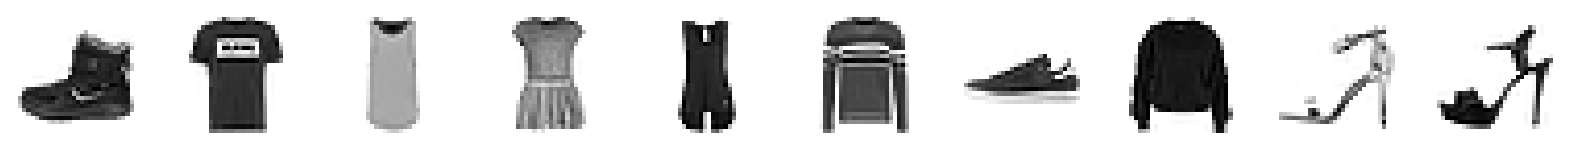

In [15]:
# Show some items of clothing from the training set
display(x_train)

Давайте теперь попробуем понять, что нужно сделать с рассмотренной ранее моделью автокодировщика (AE), чтобы преобразовать ее в вариационный автокодировщик (VAE) и, таким образом, сделать ее более сложной генеративной моделью.

Две части, которые нам нужно изменить, — это __кодировщик__ и __функция потерь__.


### Кодировщик

В автокодировщике каждому изображению сопоставляется непосредственно одна точка скрытого пространства. В вариационном автокодировщике каждое изображение вместо этого отображается в многомерное нормальное распределение вокруг точки в скрытом пространстве, как показано на рисунке.

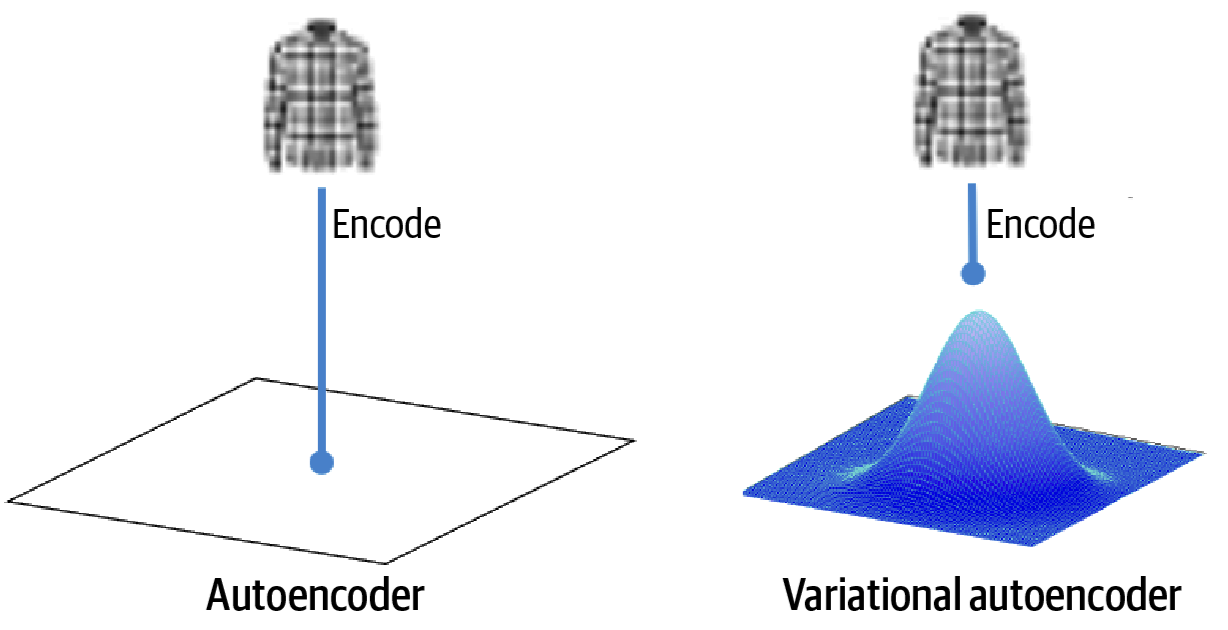

### Многомерное нормальное распределение

Нормальное распределение (или распределение Гаусса) $\mathcal{N}\left(\mu,\sigma^2\right)$
представляет собой распределение вероятностей, характеризующееся характерной формой колоколообразной кривой, определяемой двумя переменными: средним ($\mu$) и дисперсией ($\sigma^2$). Стандартное отклонение ($\sigma$) — это квадратный корень из дисперсии.

Функция плотности вероятности (pdf) нормального распределения в одном измерении равна:

$$f\left(x\mid\mu,\sigma^{2}\right)=\frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{\left(x-\mu\right)^{2}}{2\sigma^{2}}}$$

Можно делать выборку $z$ из нормального распределения со средним значением $\mu$ и стандартным отклонением $\sigma$, используя следующее уравнение:

$$z=\mu+\sigma\,\epsilon,\,\epsilon\sim\mathcal{N}\left(0,1\right),$$

где $\epsilon$ выбирается из стандартного нормального распределения.

Концепция нормального распределения распространяется на более чем на одно измерение — функцию плотности вероятности для многомерного ($d$-мерного) нормального распределения (или многомерного распределения Гаусса) $\mathcal{N}\left(\boldsymbol{\mu},\boldsymbol{\Sigma}\right)$
со средним вектором $\boldsymbol{\mu}$
и симметричной ковариационной матрицей $\boldsymbol{\Sigma}$
следующим образом:

$$f\left(\mathbf{x}\mid\boldsymbol{\mu},\boldsymbol{\Sigma}\right)=\frac{1}{\left(2\pi\right)^{d/2}\sqrt{\left|\boldsymbol{\Sigma}\right|}}exp\left(-\frac{1}{2}\left(\mathbf{x}-\boldsymbol{\mu}\right)^{T}\boldsymbol{\Sigma}^{-1}\left(\mathbf{x}-\boldsymbol{\mu}\right)\right)$$

Обычно используются изотропные многомерные нормальные распределения, где ковариационная матрица диагональна. Это означает, что распределение независимо в каждом измерении (т.е. можно выбрать вектор, в котором каждый элемент нормально распределен с независимым средним значением и дисперсией). Это относится к многомерному нормальному распределению, которое будет использоваться в нашем вариационном автокодировщике.

Многомерное стандартное нормальное распределение $\mathcal{N}\left(\mathbf{0},\mathbf{I}\right)$ — это многомерное распределение с нулевым средним вектором $\mathbf{0}$ и единичной ковариационной матрицей $\mathbf{I}$.

Кодировщику нужно только сопоставить каждым входным данным вектор средних значений и вектор дисперсий, и ему не нужно беспокоиться о ковариации между измерениями. Вариационные автокодировщики предполагают, что между измерениями в скрытом пространстве нет корреляции.

Значения дисперсии всегда положительны, поэтому фактически выбирается отображение в логарифм дисперсии, поскольку логарифм может принимать любое действительное значение в диапазоне $\left(-\infty,+\infty\right)$. Таким образом, можно использовать нейронную сеть в качестве кодировщика для выполнения сопоставления входному изображению векторов  средних значений и логарифмов дисперсии.

Подводя итог, кодировщик получит на входе изображение и закодирует его в два вектора, которые вместе определяют многомерное нормальное распределение в скрытом пространстве:

* `z_mean` – средняя точка распределения
* `z_log_var` - логарифм дисперсии каждого измерения

Можно выбрать точку $z$ из распределения, определяемого этими значениями, используя следующее уравнение:

`z = z_mean + z_sigma * epsilon`,

где `z_sigma = exp(z_log_var * 0.5)`, `epsilon ~ N(0,I)`.

Вывод связи между `z_sigma` ($\sigma$) и `z_log_var` ($\log\sigma^2$) выглядит следующим образом:

$$\sigma=\exp\left(\log\left(\sigma\right)\right)=\exp\left(2\log\left(\sigma\right)/2\right)=\exp\left(\log\left(\sigma^{2}\right)/2\right)$$

Декодер вариационного автокодировщика идентичен декодеру обычного автокодировщика, что приводит к следующей архитектуре, показанной на рисунке:

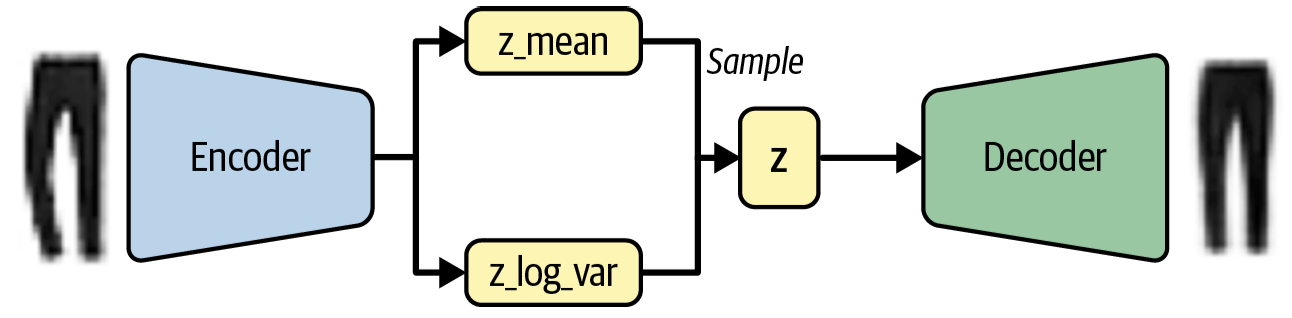

Почему это небольшое изменение в кодировщике улучшает работу автокодировщика?

Ранее мы видели, что не требуется, чтобы скрытое пространство было непрерывным — даже если точка (–2, 2) декодируется в правильно сформированное изображение сандалии, требований, чтобы изображение для близкой точки (–2.1, 2.1) выглядело похожим нет. Теперь, поскольку мы выбираем случайную точку из области вокруг `z_mean`, декодер должен гарантировать, что все точки в одной окрестности создают очень похожие изображения при декодировании, чтобы потери при реконструкции оставались небольшими. Это очень хорошее свойство, которое гарантирует, что даже когда мы выберем точку в скрытом пространстве, которая никогда не была видна декодером, она, скорее всего, будет декодирована в правильно сформированное изображение.

## Построение вариационного автокодировщика

Во-первых, нам нужно создать новый тип слоя `Sampling`, который позволит нам осуществлять выборку из распределения, определенного `z_mean` и `z_log_var`.

In [16]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim)) 
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

Здесь был создан новый слой `Sampling` как подкласс базового класса `Layer`.

В Keras можно создавать новые слои как подклассы абстрактного класса `Layer`, определяя метод `call`, который описывает, как слой преобразует входной тензор.
Например, в вариационном автокодировщике можно создать слой `Sampling`, который будет обрабатывать выборку `z` из нормального распределения с параметрами, определенными `z_mean` и `z_log_var`.

Это полезно, когда вы хотите применить к тензору такое преобразование, которое еще не включено в качестве одного из готовых типов слоев Keras.

Также в слое `Sampling` использован трюк с перепараметризацией (reparameterization trick), чтобы построить выборку из нормального распределения, параметризованного `z_mean` и `z_log_var`. 

Вместо того, чтобы производить выборку непосредственно из нормального распределения с параметрами `z_mean` и `z_log_var`, мы выбираем переменную `epsilon` из стандартного нормального распределения, а затем вручную корректируем выборку, чтобы получить правильное среднее значение и дисперсию.

Это известно как трюк с перепараметризацией, и он важен, поскольку означает, что градиенты могут свободно распространяться обратно по слою. Сохраняя всю случайность слоя, содержащуюся в переменной `epsilon`, можно показать, что частная производная выхода слоя по отношению к его входу является детерминированной (независимой от случайной переменной `epsilon`), что важно для возможности обратного распространения ошибки через слой.

Полный код кодировщика, включая обращение к новому слою `Sampling`, показан ниже.

In [17]:
# Encoder
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, 1), name="encoder_input"
)
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(
    encoder_input
)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
shape_before_flattening = x.shape[1:]  # the decoder will need this!

x = layers.Flatten()(x)
z_mean = layers.Dense(EMBEDDING_DIM, name="z_mean")(x)
z_log_var = layers.Dense(EMBEDDING_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 16, 16,    │        320 │ encoder_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 8, 8, 64)  │     18,496 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 4, 4, 128) │     73,856 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2048)      │          0 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │      4,098 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │      4,098 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 100,868 (394.02 KB)

 Trainable params: 100,868 (394.02 KB)

 Non-trainable params: 0 (0.00 B)

Вместо того, чтобы напрямую подключать слой `Flatten` к скрытому двумерному пространству, мы подключаем его к слоям `z_mean` и `z_log_var`.

Слой `Sampling` выбирает точку `z` в скрытом пространстве из нормального распределения, определенного параметрами `z_mean` и `z_log_var`.

Модель Keras, определяющая кодировщик — это модель, которая принимает входное изображение и выводит значения `z_mean`, `z_log_var` и случайную точку `z` из нормального распределения, определенного этими параметрами.

Декодер остается прежним:

In [18]:
# Decoder
decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    32, (3, 3), strides=2, activation="relu", padding="same"
)(x)
decoder_output = layers.Conv2D(
    1,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Conv2D)         │ (None, 32, 32, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,273 (962.00 KB)

 Trainable params: 246,273 (962.00 KB)

 Non-trainable params: 0 (0.00 B)

Кроме __кодировщика__, в исходном автокодировщике нам нужно изменить __функцию потерь__.

### Функция потерь

Раньше функция потерь состояла только из потерь реконструкции между исходными изображениями и их копиями после прохождения через кодировщик и декодер. Потери при реконструкции также остаются в вариационном автокодировщике, но теперь нужен один дополнительный компонент: слагаемое с __дивергенцией Кульбака-Лейблера__ (KL-дивергенцией).

KL-дивергенция — это способ измерения того, насколько одно распределение вероятностей отличается от другого. В VAE мы хотим измерить, насколько наше нормальное распределение с параметрами `z_mean` и `z_log_var` отличается от стандартного нормального распределения. В этом частном случае можно показать, что КЛ-дивергенция имеет следующий замкнутый вид:

```python
kl_loss = -0.5 * sum(1 + z_log_var - z_mean ^ 2 - exp(z_log_var))
```
или в математической записи:

$$D_{\mathbb{KL}}\left(\mathcal{N}\left(\mu,\sigma\right)\parallel\mathcal{N}\left(0,1\right)\right)=-\frac{1}{2}\sum_{i}\left(1+\log\left(\sigma_{i}^{2}\right)-\mu_{i}^{2}-\sigma_{i}^{2}\right)$$

Сумма берется по всем измерениям скрытого пространства. Значение `kl_loss` минимизируется до 0, когда `z_mean = 0` и `z_log_var = 0` для всех измерений. Когда эти два члена начинают отличаться от 0, значение `kl_loss` увеличивается.

Таким образом, слагаемое KL-дивергенции штрафует нейронную сеть за кодирование данных в переменные `z_mean` и `z_log_var`, которые значительно отличаются от параметров стандартного нормального распределения, а именно `z_mean = 0` и `z_log_var = 0`.

Почему это дополнение к функции потерь помогает улучшить модель?

Во-первых, теперь у нас есть четко определенное распределение, которое мы можем использовать для выбора точек в скрытом пространстве — стандартное нормальное распределение. Во-вторых, поскольку это слагаемое пытается приблизить все закодированные распределения к стандартному нормальному распределению, вероятность образования больших промежутков между кластерами точек меньше. Вместо этого кодировщик попытается использовать пространство вокруг начала координат симметрично и эффективно.

В исходной статье по VAE функция потерь для VAE представляла собой просто сумму потерь реконструкции и потерь KL-дивергенции. Как вариант, можно использовать коэффициент, который взвешивает KL-дивергенцию, чтобы гарантировать, что сбалансированность с потерями при реконструкции (β-VAE). Если дать слишком большой вес потерям при реконструкции, то потери KL-дивергенции не будут иметь желаемого регулирующего эффекта, и мы увидим те же проблемы, которые мы испытали с простым автоэнкодером. Если дать слишком большой вес слагаемому KL-дивергенции, то потери KL-дивергенции  будут доминировать, и восстановленные изображения будут плохими. Этот весовой коэффициент является одним из параметров, которые необходимо настроить при обучении VAE.

### Обучение вариационного автокодировщика

Построим модель VAE как подкласс абстрактного класса `Model`. Это позволяет включить вычисление слагаемого KL-дивергенции в функции потерь в метод `train_step`.

In [19]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    # Эта функция формирует выходные данные VAE для конкретного входного изображения
    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    # Эта функция описывает один шаг обучения VAE, включая расчет функции потерь
    def train_step(self, data):
        """Step run during training."""
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(
                BETA
                * losses.binary_crossentropy(
                    data, reconstruction, axis=(1, 2, 3)
                )
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            # Общие потери представляют собой сумму потерь реконструкции и 
            # потерь KL-дивергенции
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA
            * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3))
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

Конструкция `GradientTape` фреймворка TensorFlow — это механизм, который позволяет вычислять градиенты операций, выполняемых во время прямого прохода модели. Чтобы использовать его, необходимо обернуть код, выполняющий операции, которые вы хотите дифференцировать, в контекст `tf.GradientTape()`. После того, как операции записаны, можно вычислить градиент функции потерь по отношению к некоторым переменным, вызвав `tape.gradient()`. Затем градиенты можно использовать для обновления переменных с помощью оптимизатора.
Этот механизм полезен для расчета градиента пользовательских функций потерь (как показано выше), а также для создания пользовательских циклов обучения.

Теперь создадим вариационный автокодировщик как объект класса `VAE`:

In [20]:
# Create a variational autoencoder
vae = VAE(encoder, decoder)

Скомпилируем модель, выбирая в качестве оптимизатора `Adam`:

In [21]:
# Compile the variational autoencoder
optimizer = optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer)

Обучим модель вариационного автокодировщика:

In [22]:
vae.fit(
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test, x_test),
)

Epoch 1/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - kl_loss: 3.7145 - reconstruction_loss: 194.2165 - total_loss: 197.9310 - val_kl_loss: 4.8888 - val_loss: 140.3839 - val_reconstruction_loss: 135.4951
Epoch 2/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - kl_loss: 4.9885 - reconstruction_loss: 131.5902 - total_loss: 136.5787 - val_kl_loss: 4.9888 - val_loss: 137.9120 - val_reconstruction_loss: 132.9232
Epoch 3/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - kl_loss: 5.0467 - reconstruction_loss: 129.6259 - total_loss: 134.6727 - val_kl_loss: 5.1328 - val_loss: 137.1871 - val_reconstruction_loss: 132.0543
Epoch 4/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - kl_loss: 5.0966 - reconstruction_loss: 128.3519 - total_loss: 133.4485 - val_kl_loss: 5.2474 - val_loss: 136.2776 - val_reconstruction_loss: 131.0302
Epoch 5/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - kl_loss: 5.1358 - reconstruction_loss: 127.5396 - total_loss: 132.6755 - val_kl_loss: 5.3158 - val_loss: 135.5642 - val_recon

### Реконструкция при помощи вариационного автокодировщика

Теперь, когда мы обучили наш VAE, мы можем использовать кодировщик для кодирования изображений в тестовом наборе и построения значений `z_mean` в скрытом пространстве. Мы также можем выполнить выборку из стандартного нормального распределения, чтобы сгенерировать точки в скрытом пространстве, и использовать декодер для декодирования этих точек обратно в пространство пикселей, чтобы увидеть, как работает VAE.

In [23]:
# Select a subset of the test set
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Example real clothing items


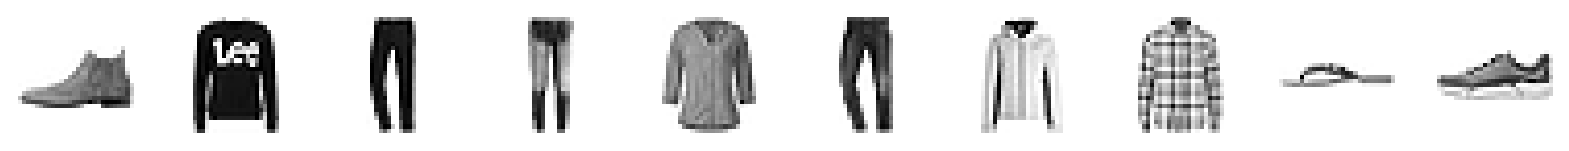

Reconstructions


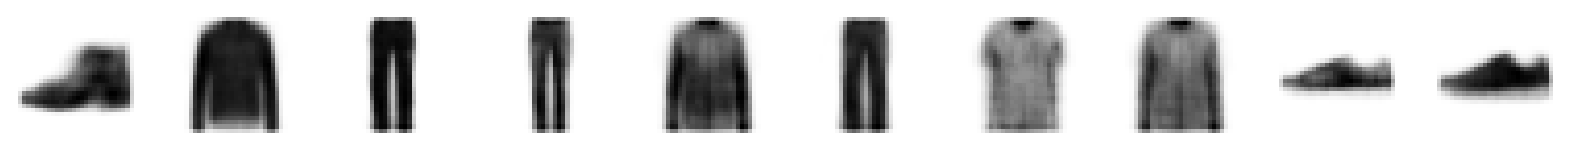

In [24]:
# Create autoencoder predictions and display
z_mean, z_log_var, reconstructions = vae.predict(example_images)
print("Example real clothing items")
display(example_images)
print("Reconstructions")
display(reconstructions)

### Вложение (эмбеддинг) с помощью кодировщика <a name="encode"></a>

Преобразуем изображения (в тройку `z_mean`, `z_var`, `z`) при помощи кодировщика:

In [25]:
# Encode the example images
z_mean, z_var, z = encoder.predict(example_images)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [26]:
# Some examples of the embeddings
print(z[:10])

[[-1.1510081  -1.0222851 ]
 [-0.16078608  0.82538545]
 [ 2.2555254   1.0173693 ]
 [ 2.2118397  -0.23551589]
 [ 0.0350306   0.22654113]
 [ 1.5296584   0.55160767]
 [ 0.6215822  -0.64105576]
 [ 0.3620605  -0.14969043]
 [ 0.65696704 -2.6998992 ]
 [-0.5102358  -1.7924601 ]]


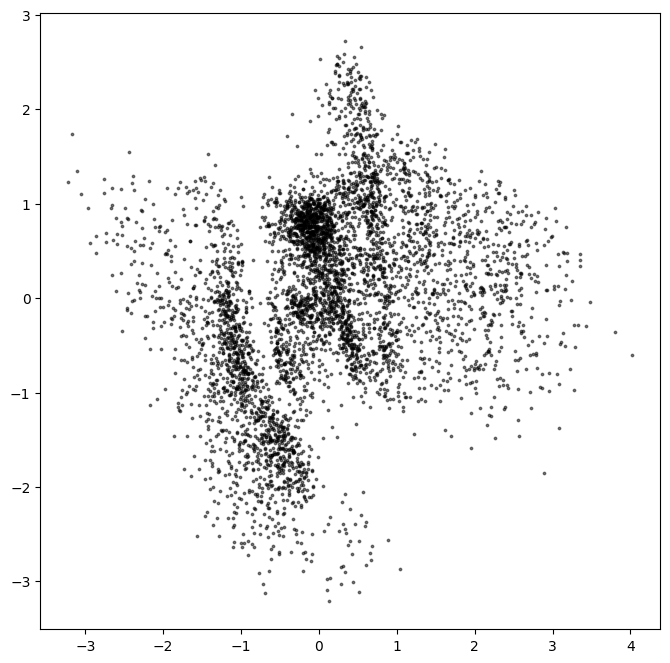

In [27]:
# Show the encoded points in 2D space
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=3)
plt.show()

### Генерация при помощи декодера

Можно сгенерировать новые изображения, выбирая некоторые точки в скрытом пространстве и используя декодер для преобразования их обратно в пространство пикселей.

In [28]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (6, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, 2))

In [29]:
# Decode the sampled points
reconstructions = decoder.predict(z_sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


In [30]:
# Convert original embeddings and sampled embeddings to cdf values
# cdf – cumulative distribution function
p = norm.cdf(z)
p_sample = norm.cdf(z_sample)

На рисунке ниже показана структура нового скрытого пространства, а также некоторые точки выборки и их декодированные изображения. Мы сразу можем увидеть несколько изменений в организации скрытого пространства.


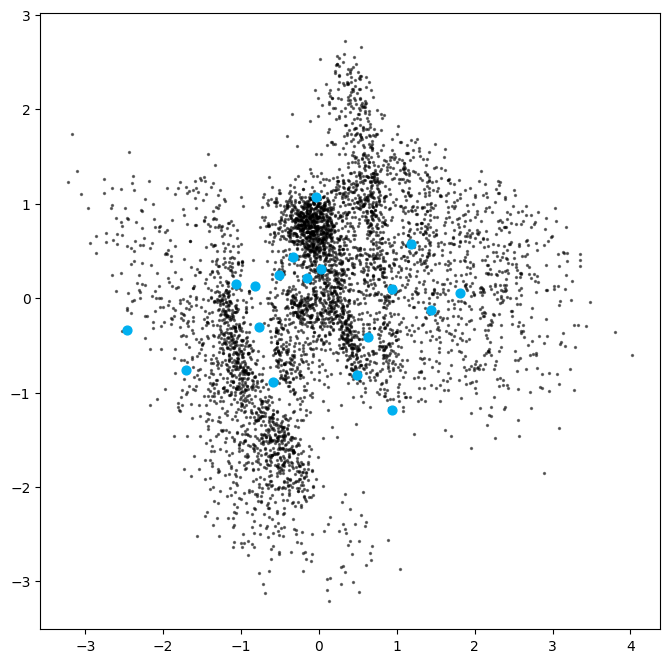

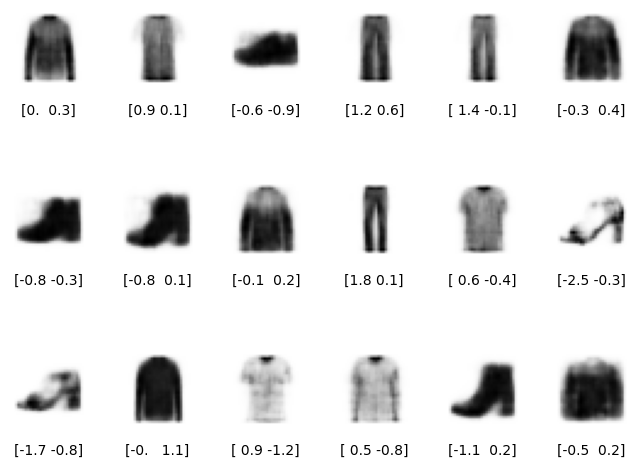

In [31]:
# Draw a plot of...
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(z_sample[:, 0], z_sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(z_sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

В новом скрытом пространстве черные точки показывают значение `z_mean` каждого закодированного изображения, а синие точки показывают некоторые точки выборки в скрытом пространстве (с их декодированными изображениями справа).

### Исследование скрытого пространства

Во-первых, слагаемое потерь KL-дивергенции гарантирует, что значения `z_mean` и `z_log_var` закодированных изображений никогда не отклоняются слишком далеко от стандартного нормального распределения. Во-вторых, не так много плохо сформированных изображений, поскольку скрытое пространство теперь гораздо более непрерывное, благодаря тому, что кодировщик теперь стохастический, а не детерминированный.



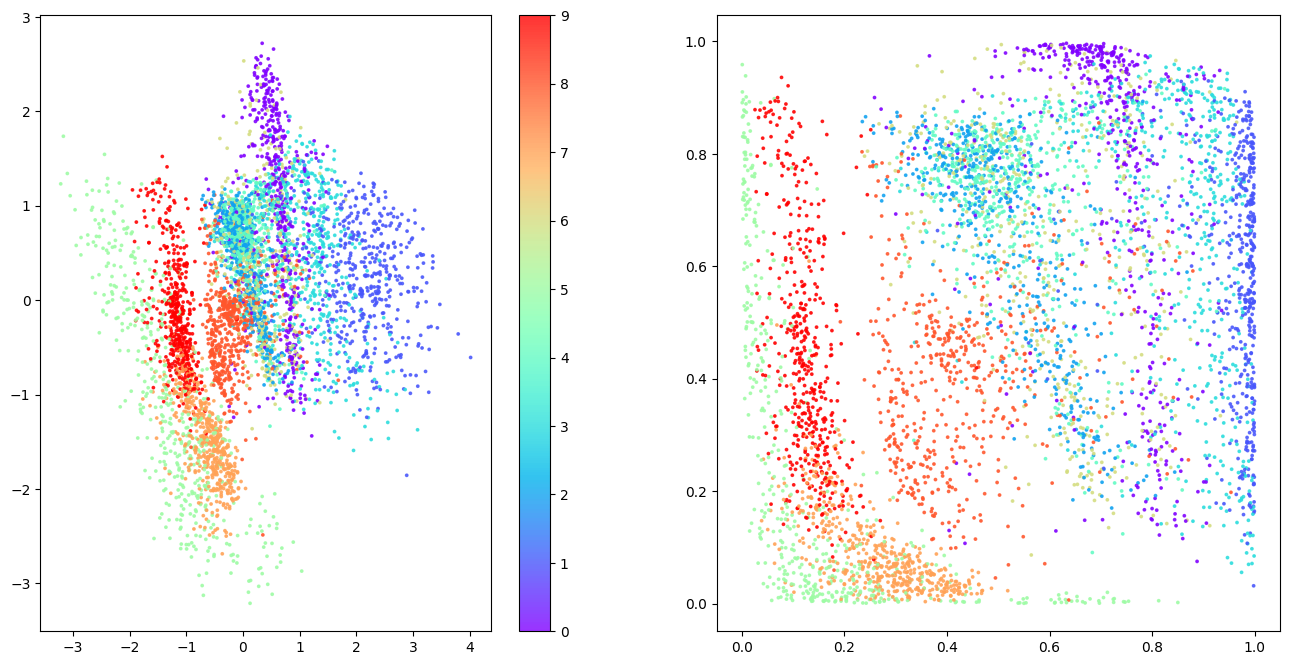

In [32]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 8
fig = plt.figure(figsize=(figsize * 2, figsize))
ax = fig.add_subplot(1, 2, 1)
plot_1 = ax.scatter(
    z[:, 0], z[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.colorbar(plot_1)
ax = fig.add_subplot(1, 2, 2)
plot_2 = ax.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.show()

| ID | Clothing Label |
| :- | :- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

Раскрашивая точки в скрытом пространстве по типам одежды (рисунки выше), мы видим, что не существует предпочтения какого-либо одного типа. Правый рисунок показывает пространство, преобразованное в значения cdf — мы видим, что каждый цвет представлен примерно одинаково. Опять же, важно помнить, что во время обучения метки вообще не использовались – VAE самостоятельно изучил различные формы одежды, чтобы минимизировать потери при реконструкции.

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


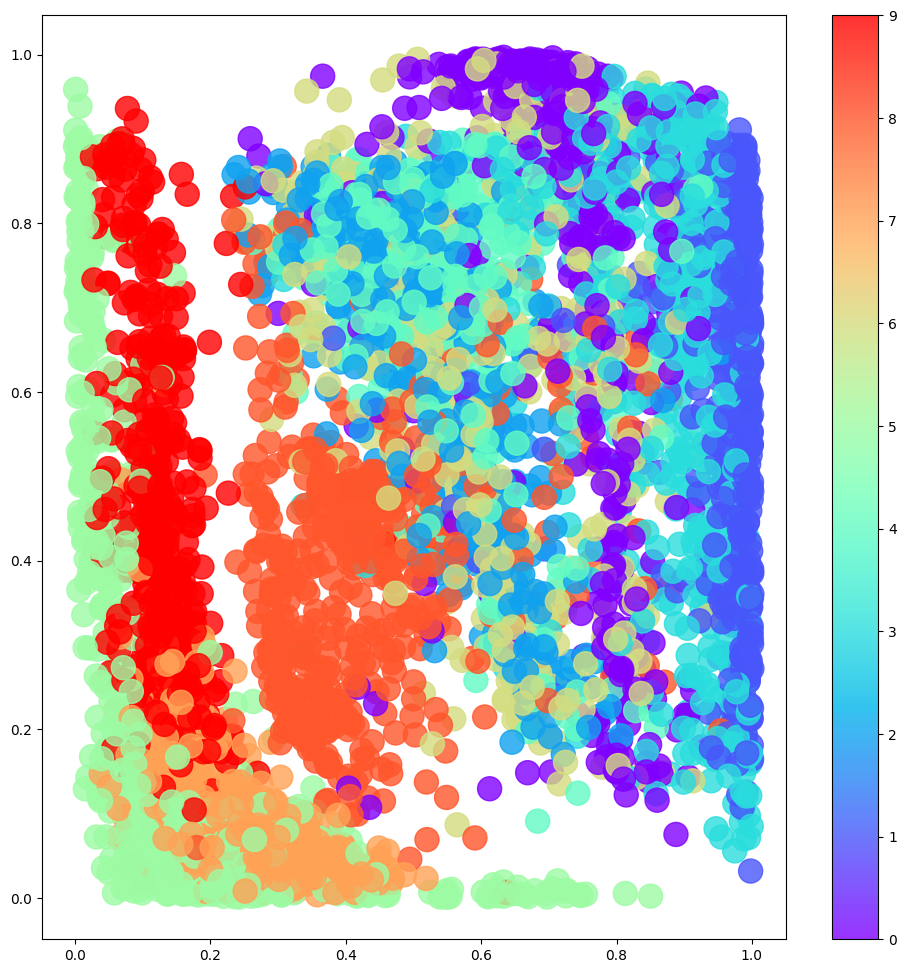

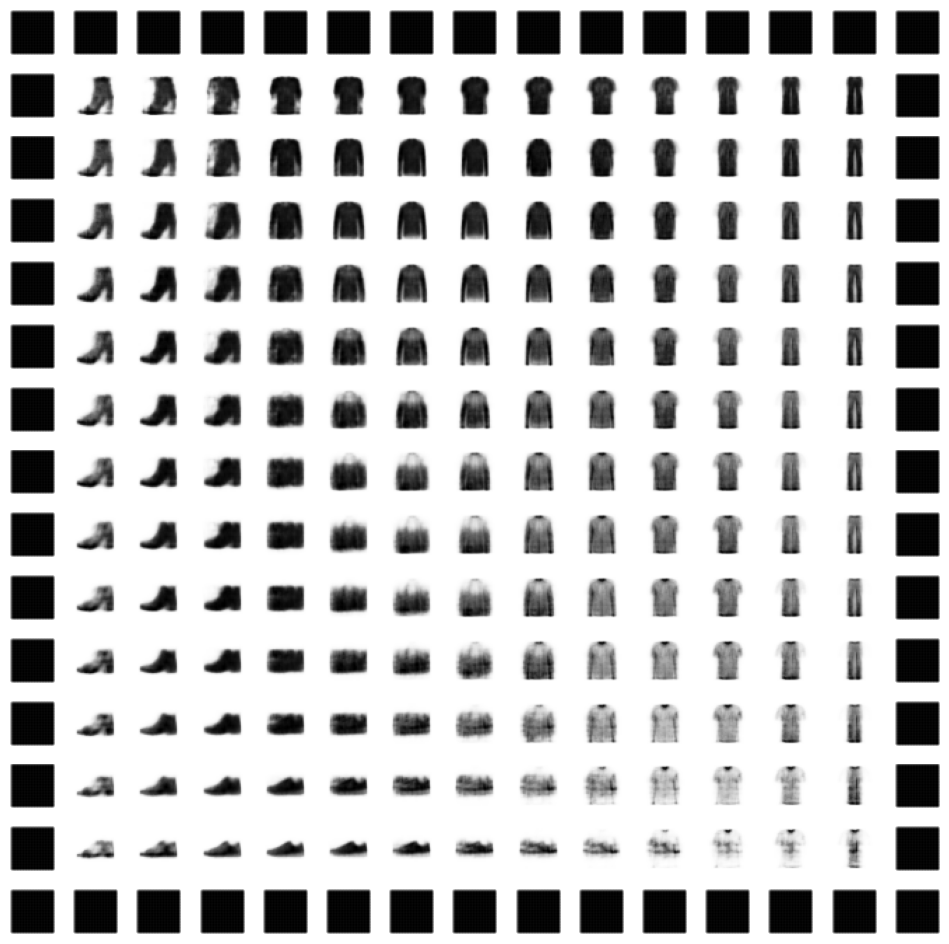

In [33]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=300
)
plt.colorbar()

# ppf – percent point function (inverse of cdf — percentiles)
x = norm.ppf(np.linspace(0, 1, grid_size))
y = norm.ppf(np.linspace(1, 0, grid_size))
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

### Работа с набором данных CelebA Faces 🤪 

До сих пор мы ограничивались скрытым пространством с двумя измерениями. Это помогло нам визуализировать внутреннюю работу VAE и понять, почему небольшие изменения, которые мы внесли в архитектуру автокодировщика, помогли превратить ее в более мощный класс нейронных сетей, который можно использовать для задач генеративного моделирования.
Теперь обратим внимание на более сложный набор данных и посмотрим, чего могут достичь вариационные автокодировщики, когда мы увеличиваем размерность скрытого пространства.

#### Набор данных CelebA

Будем использовать набор данных __CelebFaces Attributes (CelebA)__ для обучения нашего следующего вариационного автокодировщика. Это коллекция из более чем 200 000 цветных изображений лиц знаменитостей, каждое из которых снабжено различными надписями (например, в шляпе, улыбается и т. д.).


In [34]:
import tensorflow as tf
from scipy.stats import norm
import pandas as pd

from utils import sample_batch, display

from vae_utils import get_vector_from_label, add_vector_to_images, morph_faces

## Параметры <a name="parameters"></a>

In [35]:
IMAGE_SIZE = 64
CHANNELS = 3
BATCH_SIZE = 128
NUM_FEATURES = 64
Z_DIM = 200
LEARNING_RATE = 0.0005
EPOCHS = 10
BETA = 2000
LOAD_MODEL = False

In [36]:
import os
# Create subdirectories
for path in ["./checkpoint","./logs","./models","./output"]:
    try:
        os.mkdir(path)
        print("Directory '%s' created successfully" % path)
    except OSError as error:
        print("Directory '%s' exists" % path)


Directory './checkpoint' exists
Directory './logs' exists
Directory './models' exists
Directory './output' exists


## Подготовка данных 

Для обучения VAE метки лиц не нужны, но они пригодятся позже, когда мы начнем изучать, как эти функции фиксируются в многомерном скрытом пространстве. Как только наш VAE будет обучен, мы сможем выбирать точки из скрытого пространства, чтобы генерировать новые примеры лиц знаменитостей.

Набор данных CelebA доступен через Kaggle:

`https://www.kaggle.com/datasets/jessicali9530/celeba-dataset/data`

Мы используем функцию Keras `image_dataset_from_directory` для создания набора данных TensorFlow по ссылке на каталог, в котором хранятся изображения. Это позволяет считывать пакеты изображений в память только тогда, когда это необходимо (например, во время обучения), так что можно работать с большими наборами данных и не беспокоиться о необходимости размещения всего набора данных в памяти. Также изменяем размер изображений до 64×64, интерполируя значения пикселей.

In [37]:
# Load the data from kaggle (>1GB)
# https://www.kaggle.com/datasets/jessicali9530/celeba-dataset/data
# and tune directories for data
train_data = utils.image_dataset_from_directory(
    "celeba-dataset/img_align_celeba/img_align_celeba",
    labels=None,
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

Found 202599 files.


Исходные данные масштабируются в диапазоне [0, 255] для интенсивности пикселей, которую мы перемасштабируем до диапазона [0, 1].

In [38]:
# Preprocess the data
def preprocess(img):
    img = tf.cast(img, "float32") / 255.0
    return img


train = train_data.map(lambda x: preprocess(x))

In [39]:
train_sample = sample_batch(train)

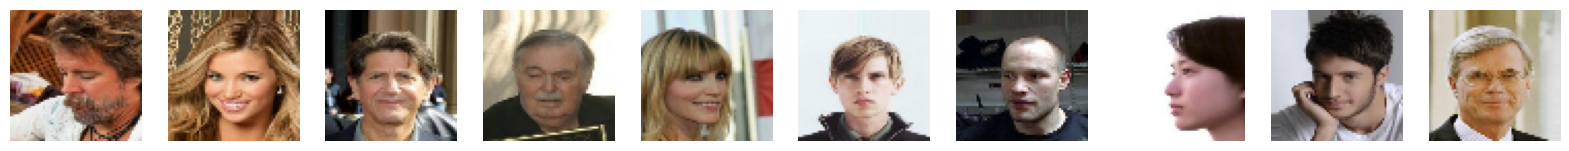

In [40]:
# Show some faces from the training set
display(train_sample, cmap=None)

## Построение вариационного автокодировщика

Архитектура модели нейронной сети для лиц аналогична примеру Fashion-MNIST с некоторыми небольшими отличиями:
* Наши данные теперь имеют три входных канала (RGB) вместо одного (оттенки серого). Это означает, что нам нужно изменить количество каналов в последнем слое сверточного транспонирования декодера на 3.
* Будем использовать скрытое пространство с 200 измерениями вместо 2. Поскольку лица намного сложнее, чем изображения Fashion-MNIST, мы увеличиваем размерность скрытого пространства, чтобы сеть могла кодировать удовлетворительное количество деталей из изображений. 
* После каждого сверточного слоя имеются слои пакетной нормализации для стабилизации обучения. Несмотря на то, что обработка каждой партии занимает больше времени, количество партий, необходимых для достижения тех же потерь, значительно сокращается.
* Увеличиваем коэффициент β для KL-дивергенции до 2000. Это параметр, требующий настройки, но для этого набора данных и архитектуры это значение дает хорошие результаты.

In [41]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [42]:
# Encoder
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name="encoder_input"
)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(
    encoder_input
)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
shape_before_flattening = x.shape[1:]  # the decoder will need this!

x = layers.Flatten()(x)
z_mean = layers.Dense(Z_DIM, name="z_mean")(x)
z_log_var = layers.Dense(Z_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │      1,792 │ encoder_input[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 16, 16,    │     36,928 │ leaky_re_lu[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 8, 8, 64)  │     36,928 │ leaky_re_lu_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 64)  │        256 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 8, 8, 64)  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 4, 4, 64)  │     36,928 │ leaky_re_lu_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 64)  │        256 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 4, 4, 64)  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 2, 2, 64)  │     36,928 │ leaky_re_lu_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2, 2, 64)  │        256 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 2, 2, 64)  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 256)       │          0 │ leaky_re_lu_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 200)       │     51,400 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 253,584 (990.56 KB)

 Trainable params: 252,944 (988.06 KB)

 Non-trainable params: 640 (2.50 KB)

In [43]:
# Decoder
decoder_input = layers.Input(shape=(Z_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
decoder_output = layers.Conv2DTranspose(
    CHANNELS, kernel_size=3, strides=1, activation="sigmoid", padding="same"
)(x)
decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        51,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 4, 4, 64)       │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 4, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 8, 8, 64)       │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 16, 16, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 32, 32, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 64, 64, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 240,131 (938.01 KB)

 Trainable params: 238,979 (933.51 KB)

 Non-trainable params: 1,152 (4.50 KB)

In [44]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """Step run during training."""
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data, training=True)
            reconstruction_loss = tf.reduce_mean(
                BETA * losses.mean_squared_error(data, reconstruction)
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA * losses.mean_squared_error(data, reconstruction)
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [45]:
# Create a variational autoencoder
vae = VAE(encoder, decoder)

## Обучение вариационного автокодировщика

In [46]:
# Compile the variational autoencoder
optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
vae.compile(optimizer=optimizer)

In [47]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint.keras",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.decoder(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = utils.array_to_img(generated_images[i])
            img.save("./output/generated_img_%03d_%d.png" % (epoch, i))

In [48]:
# Load old weights if required
if LOAD_MODEL:
    vae.load_weights("./models/vae")
    tmp = vae.predict(train.take(1))

In [49]:
vae.fit(
    train,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator(num_img=10, latent_dim=Z_DIM),
    ],
)

Epoch 1/10
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 96s 58ms/step - kl_loss: 11.6132 - loss: 105.1768 - reconstruction_loss: 93.5636
Epoch 2/10
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 93s 58ms/step - kl_loss: 14.6037 - loss: 71.2797 - reconstruction_loss: 56.6759
Epoch 3/10
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 94s 59ms/step - kl_loss: 15.7101 - loss: 67.4548 - reconstruction_loss: 51.7447
Epoch 4/10
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 95s 60ms/step - kl_loss: 16.1794 - loss: 65.8566 - reconstruction_loss: 49.6772
Epoch 5/10
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 94s 59ms/step - kl_loss: 16.4578 - loss: 65.0810 - reconstruction_loss: 48.6232
Epoch 6/10
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 94s 59ms/step - kl_loss: 16.7174 - loss: 64.3999 - reconstruction_loss: 47.6826
Epoch 7/10
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 95s 60ms/step - kl_loss: 16.9450 - loss: 63.8472 - reconstruction_loss: 46.9021
Epoch 8/10
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 94s 60ms/step - kl_loss: 17.1151 - loss: 63.5592 - reconstruction_loss: 46.4441
Epoch 9/10
1583/1583 ━━

In [50]:
# Save the final models
vae.save("./models/vae.keras")
encoder.save("./models/encoder.keras")
decoder.save("./models/decoder.keras")

## Реконструкция при помощи VAE

Посмотрим на выборку реконструированных лиц. В верхнем ряду показаны исходные изображения, а в нижнем ряду показаны реконструкции после того, как они прошли через кодер и декодер.

In [51]:
# Select a subset of the test set
batches_to_predict = 1
example_images = np.array(
    list(train.take(batches_to_predict).get_single_element())
)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  
Example real faces


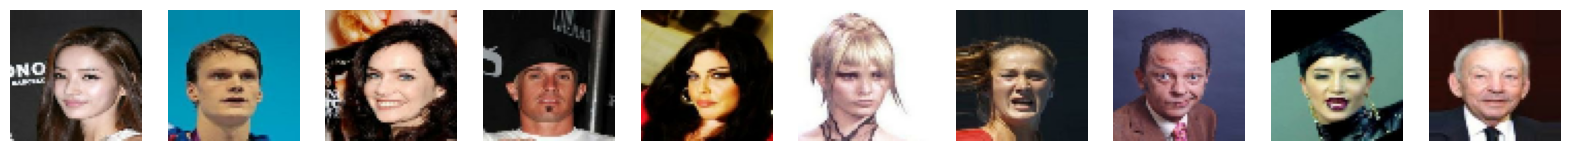

Reconstructions


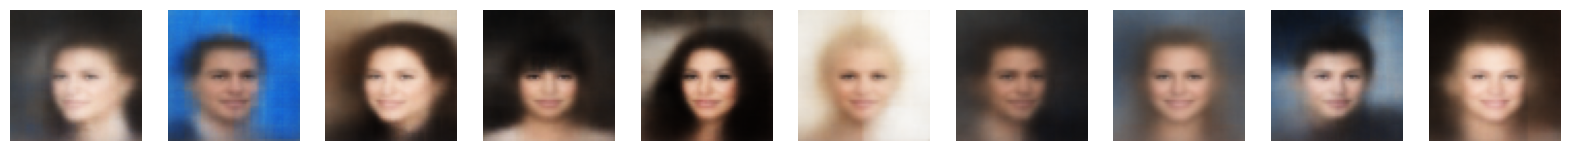

In [52]:
# Create autoencoder predictions and display
z_mean, z_log_var, reconstructions = vae.predict(example_images)
print("Example real faces")
display(example_images)
print("Reconstructions")
display(reconstructions)

VAE в целом уловил ключевые особенности каждого лица — угол наклона головы, прическу, выражение и т. д. Мелкие детали отсутствуют, но важно помнить, что цель построения вариативных автоэнкодеры не предназначены для достижения идеальной ошибки при реконструкции. Наша конечная цель — взять образец из скрытого пространства и создать новые лица.

## Распределение в скрытом пространстве

Чтобы это стало возможным, мы должны убедиться, что распределение точек в скрытом пространстве приблизительно напоминает многомерное стандартное нормальное распределение. Если мы видим какие-либо измерения, которые значительно отличаются от стандартного нормального распределения, нам, вероятно, следует уменьшить коэффициент потерь при реконструкции, поскольку слагаемое с KL-дивергенцией не имеет достаточного эффекта.
Первые 50 измерений нашего скрытого пространства показаны ниже – существенных отличий от стандартного нормального распределения нет.

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  


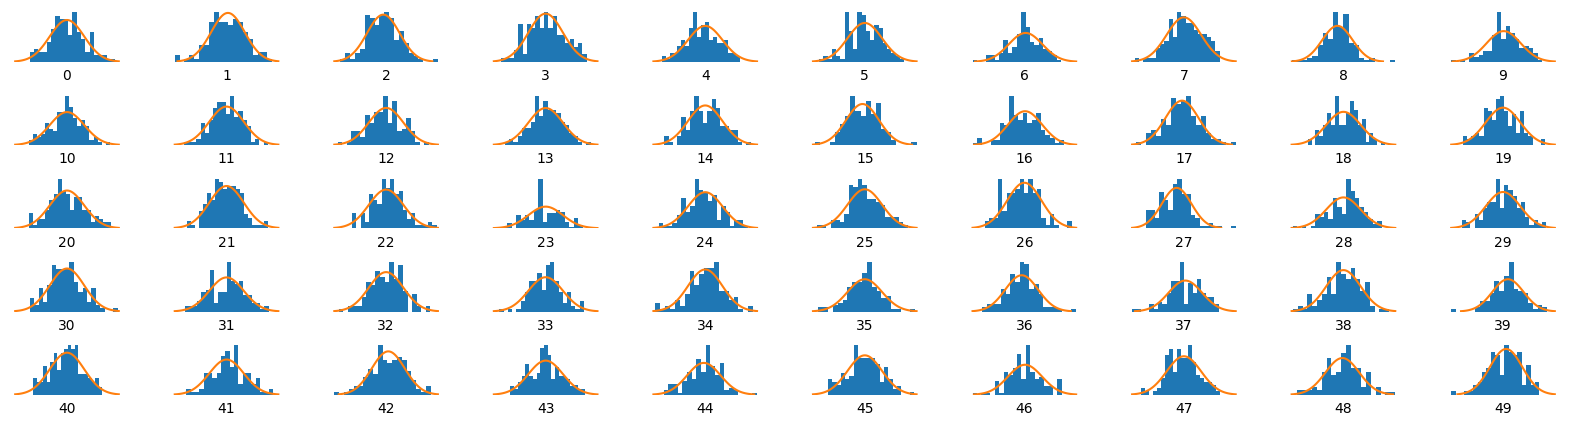

In [53]:
_, _, z = vae.encoder.predict(example_images)

x = np.linspace(-3, 3, 100)

fig = plt.figure(figsize=(20, 5))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(50):
    ax = fig.add_subplot(5, 10, i + 1)
    ax.hist(z[:, i], density=True, bins=20)
    ax.axis("off")
    ax.text(
        0.5, -0.35, str(i), fontsize=10, ha="center", transform=ax.transAxes
    )
    ax.plot(x, norm.pdf(x))

plt.show()

## Создание новых лиц

In [54]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (10, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, Z_DIM))

In [55]:
# Decode the sampled points
reconstructions = decoder.predict(z_sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


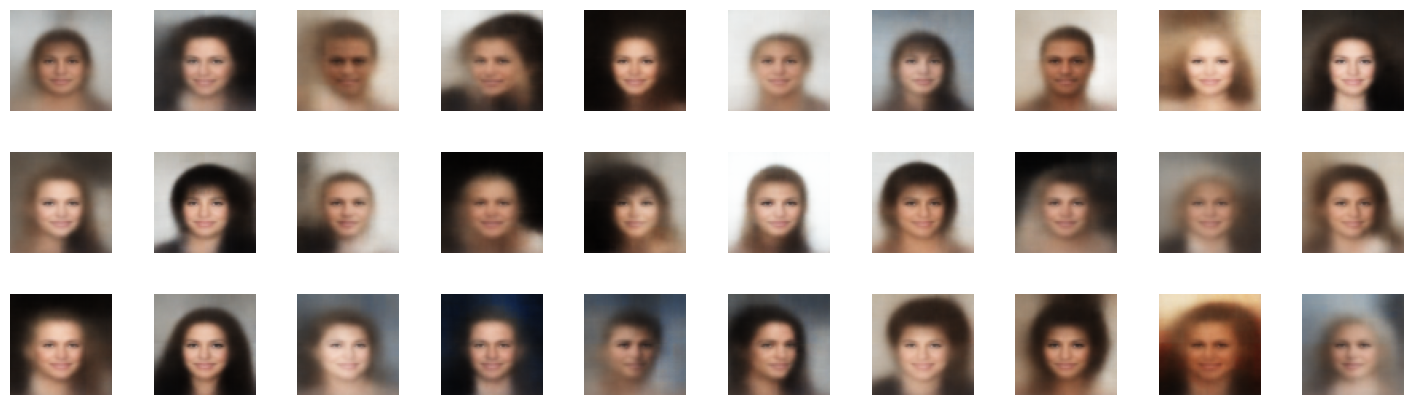

In [56]:
# Draw a plot of decoded images
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Output the grid of faces
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :])

VAE может взять набор точек, которые мы выбрали из стандартного нормального распределения, и преобразовать каждую в изображение лица человека.

## Изменение изображений

Одним из преимуществ отображения изображений в скрытое пространство меньшей размерности является то, что мы можем выполнять арифметические действия с векторами в этом скрытом пространстве, которые имеют визуальный аналог при декодировании обратно в исходную область изображения.

Например, предположим, что мы хотим сфотографировать кого-то, кто выглядит грустным, и улыбнуться ему. Для этого нам сначала нужно найти в скрытом пространстве вектор, указывающий в сторону увеличения улыбки. Добавление этого вектора к кодировке исходного изображения в скрытом пространстве даст нам новую точку, которая при декодировании должна дать нам более улыбающуюся версию исходного изображения.

Так как же нам найти вектор улыбки? Каждое изображение в наборе данных CelebA помечено атрибутами, одним из которых является «Smiling». Если мы возьмем среднее положение кодированных изображений в скрытом пространстве с атрибутом Smiling и вычтем среднее положение кодированных изображений, не имеющих атрибута Smiling, мы получим вектор, указывающий в направлении Smiling, а это именно то, что нам нужно.

Концептуально мы выполняем следующую векторную арифметику в скрытом пространстве, где `alpha` — это коэффициент, определяющий, какая часть вектора признаков добавляется или вычитается:

```python
z_new = z + alpha * feature_vector
```

In [57]:
# Load the label dataset
attributes = pd.read_csv("celeba-dataset/list_attr_celeba.csv")
print(attributes.columns)
attributes.head()

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')


image_id  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  Bags_Under_Eyes  \
0  000001.jpg                -1                1           1               -1   
1  000002.jpg                -1               -1          -1                1   
2  000003.jpg                -1               -1          -1               -1   
3  000004.jpg                -1               -1           1               -1   
4  000005.jpg                -1                1           1               -1   

   Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  ...  Sideburns  Smiling  \
0    -1     -1        -1        -1          -1  ...         -1        1   
1    -1     -1        -1         1          -1  ...         -1        1   
2    -1     -1         1        -1          -1  ...         -1       -1   
3    -1     -1        -1        -1          -1  ...         -1       -1   
4    -1     -1         1        -1          -1  ...         -1       -1   

   Straight_Hair  Wavy_Hair  Wearing_Earrings  Wearing_Hat  Wearing_Lipstick  \
0              1         -1                 1           -1                 1   
1             -1         -1                -1           -1                -1   
2             -1          1                -1           -1                -1   
3              1         -1                 1           -1                 1   
4             -1         -1                -1           -1                 1   

   Wearing_Necklace  Wearing_Necktie  Young  
0                -1               -1      1  
1                -1               -1      1  
2                -1               -1      1  
3                 1               -1      1  
4                -1               -1      1  

[5 rows x 41 columns]

In [58]:
# Load the face data with label attached
LABEL = 'Blond_Hair'  # <- Set this label
labelled_test = utils.image_dataset_from_directory(
    "celeba-dataset/img_align_celeba",
    labels=attributes[LABEL].tolist(),
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="validation",
    interpolation="bilinear",
)

labelled = labelled_test.map(lambda x, y: (preprocess(x), y))

Found 202599 files belonging to 2 classes.
Using 40519 files for validation.


In [59]:
# Find the attribute vector
attribute_vec = get_vector_from_label(labelled, vae, Z_DIM, LABEL)

label: Blond_Hair
images : POS move : NEG move :distance : 𝛥 distance
22    : 3.225    : 1.428    : 3.671    : 3.671
44    : 2.045    : 0.919    : 2.78    : -0.891
65    : 1.112    : 0.523    : 2.357    : -0.423
87    : 0.846    : 0.416    : 2.138    : -0.219
110    : 0.65    : 0.304    : 1.936    : -0.202
128    : 0.52    : 0.26    : 1.85    : -0.087
150    : 0.442    : 0.215    : 1.885    : 0.035
171    : 0.373    : 0.194    : 1.823    : -0.062
197    : 0.408    : 0.165    : 1.757    : -0.065
218    : 0.323    : 0.156    : 1.72    : -0.037
241    : 0.293    : 0.132    : 1.709    : -0.012
260    : 0.245    : 0.116    : 1.705    : -0.004
282    : 0.258    : 0.105    : 1.682    : -0.023
302    : 0.228    : 0.108    : 1.632    : -0.05
317    : 0.181    : 0.1    : 1.636    : 0.003
337    : 0.192    : 0.084    : 1.627    : -0.009
356    : 0.179    : 0.077    : 1.598    : -0.029
377    : 0.158    : 0.085    : 1.576    : -0.021
395    : 0.16    : 0.075    : 1.559    : -0.017
415    : 0.16   

Ниже показано несколько изображений, закодированных в скрытом пространстве. Затем мы добавляем или вычитаем кратные значения определенного вектора (например, «Blond_Hair»), чтобы получить разные версии изображения с изменением только соответствующего признака.

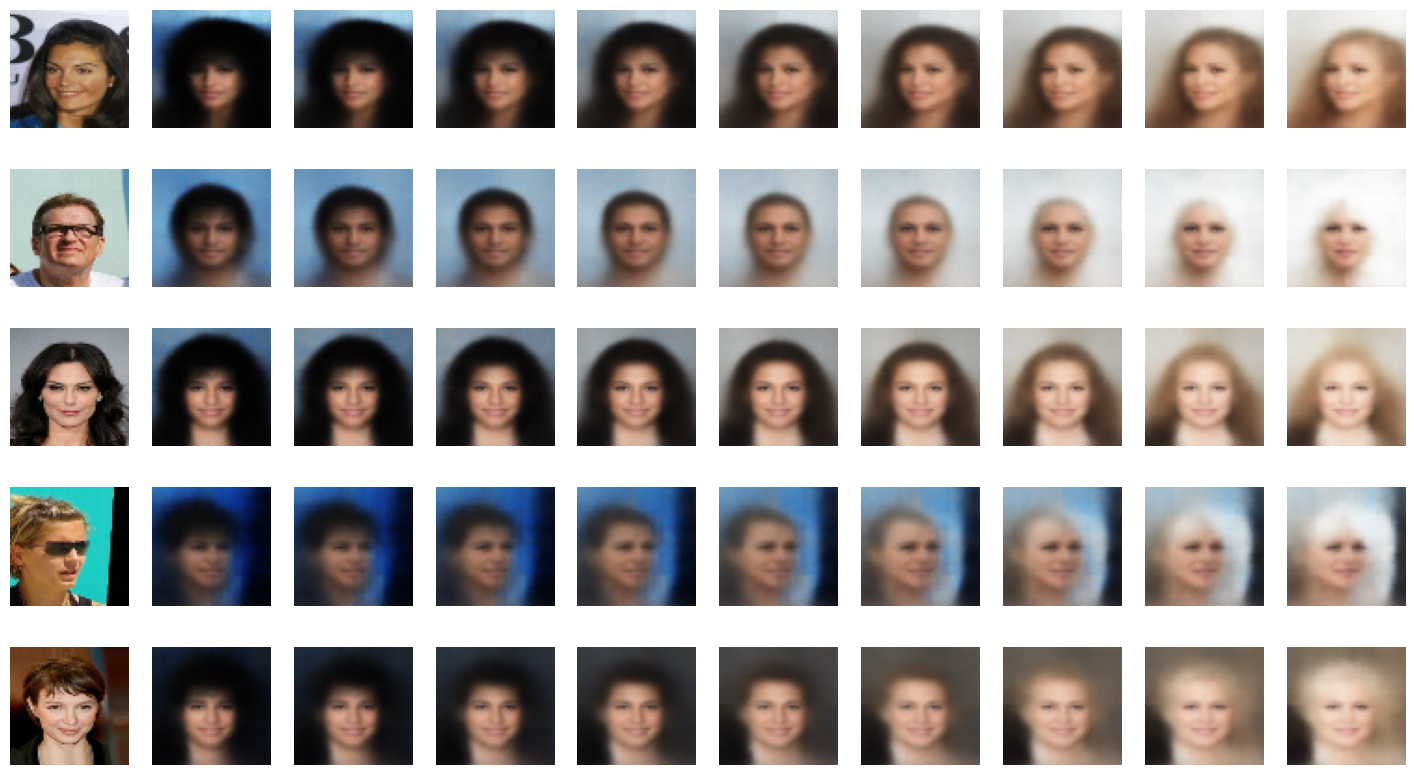

In [60]:
# Add vector to images
add_vector_to_images(labelled, vae, attribute_vec)

## Трансформация между лицами

Можно использовать аналогичную идею для трансформации между двумя лицами. Представьте себе две точки в скрытом пространстве, $А$ и $В$, которые представляют два изображения. Если бы вы начали с точки $А$ и шли к точке $B$ по прямой линии, расшифровывая по ходу каждую точку на линии, то вы бы увидели постепенный переход от начального изображения к конечному изображению.

Математически мы движемся по прямой линии, которую можно описать следующим уравнением:

```python
z_new = z_A * (1 - alpha) + z_B * alpha
```

Здесь `alpha` — это число от 0 до 1, которое определяет, насколько далеко по линии мы
находятся вдали от точки $А$.

На рисунке ниже  этот процесс показан в действии. Мы берем два изображения, кодируем их в скрытое пространство, а затем декодируем точки вдоль прямой между ними через равные промежутки.

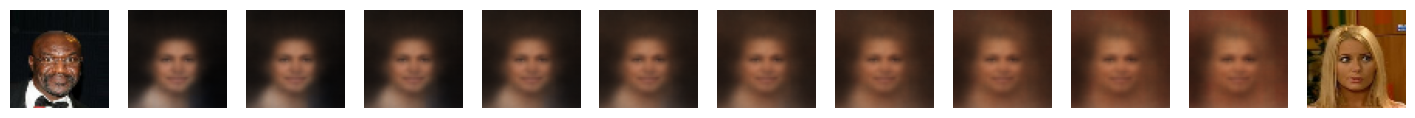

In [61]:
morph_faces(labelled, vae)

Стоит отметить плавность перехода — даже там, где необходимо одновременно изменить несколько функций (например, снятие очков, цвет волос, пол), VAE удается добиться этого плавно, показывая, что скрытое пространство VAE действительно непрерывное пространство, которое можно пересекать и исследовать, создавая множество разных человеческих лиц.

## Задание по теме №2

* Загрузите из `keras.datasets` набор данных __CIFAR10 small images classification dataset__ (https://keras.io/api/datasets/cifar10/).

* Оставьте в наборе изображения четырех классов предметов с метками, соответствующими четырем разным последним цифрам Вашего студенческого билета (например, если номер студбилета `1032259319`, то последние четыре разные цифры  – это `1, 3, 5, 9`).

* Выберите какую-либо размерность латентного пространства, создайте и обучите на обучающей выборке вариационный автокодировщик с размерностью скрытого представления, равной выбранной размерности латентного пространства.

* Выберите в наборе данных два изображения разных классов, определите точки в скрытом пространстве, соответствующие этим изображениям, выполните трансформацию между двумя выбранными изображениями и визуализируйте полученные переходные изображения.